# Site-Species Matrix Computation

In [50]:
import geopandas as gpd
import rasterio 
import numpy as np
import time
from tqdm import tqdm
from rasterio.plot import show
import os
import pandas as pd
import matplotlib.pyplot as plt

1. Import hexagon shapefile.

In [19]:
# Path to your shapefile and GeoTIFF
shapefile_path = os.path.join('grid', 'Colombia_grid_20k.shp')
if not os.path.exists(shapefile_path):
    raise FileNotFoundError('Shapefile not found at', shapefile_path)

# Load the shapefile
print('Loading shapefile...')
start_time = time.time()
hexagons = gpd.read_file(shapefile_path)
print('Shapefile loaded in', round(time.time() - start_time, 2), 'seconds')
num_hexagons = len(hexagons)
print('Number of hexagons:', num_hexagons)



Loading shapefile...
Shapefile loaded in 8.5 seconds
Number of hexagons: 186866


2. Load all species rasters.

In [24]:
raster_folder = 'bird_maps'
if not os.path.exists(raster_folder):
    raise FileNotFoundError('Raster folder not found')
rasters = [os.path.join(raster_folder, f) for f in os.listdir(raster_folder) if f.endswith('.tif')]

print(f"Number of total species rasters: {len(rasters)}")
# Mapping of species name to it's raster path.
species_raster_map = { "_".join(os.path.basename(raster_path).split('.')[0].split('_')[:2]): raster_path for raster_path in rasters }

Number of total species rasters: 1733


3. Load site-species matrix/set file to save to.

If this file already exists, the code will only compute species which haven't already been processed. 
This allows you to generate the data in stages if needed.

In [39]:
site_species_matrix_fn = 'site_species_matrix.csv'
if os.path.exists(site_species_matrix_fn):
    print('Loading site-species matrix...')
    site_species_matrix = pd.read_csv(site_species_matrix_fn, index_col="GRID_ID")
    print(f"Species already processed: {site_species_matrix.columns.tolist()}")
    # Only process species that are not already in the matrix.
    species_to_process = [species for species in species_raster_map.keys() if species not in site_species_matrix.columns]
else:
    print("Creating a new site-species matrix.")
    # Create a new site-species matrix
    site_species_matrix = pd.DataFrame(index=hexagons["GRID_ID"].tolist())
    site_species_matrix.index.name = "GRID_ID"
    species_to_process = [species for species in species_raster_map.keys()]

print(f"Number of species to process: {len(species_to_process)}")

if len(species_to_process) == 0:
    print("All species have already been processed.")

Loading site-species matrix...
Species already processed: ['Ensifera_ensifera', 'Pseudastur_albicollis', 'Hydropsalis_cayennensis', 'Charadrius_semipalmatus', 'Xiphorhynchus_elegans', 'Ortalis_guttata', 'Dendrocincla_merula', 'Brachygalba_goeringi', 'Scytalopus_latebricola', 'Chlorestes_notata', 'Attila_spadiceus']
Number of species to process: 1721


For each raster, iterate over each hexagon of the shapefile. Crop the raster to the hexagon's area, and if there are any non-zero values in the cropped region, that hexagon intersects.

In [30]:
def process_raster(raster_path, species_name, hexagons):
    print("Processing raster: ", raster_path)
    intersection_info = {
        "species": species_name,
        "intersecting_hexagons": [] 
    }

    with rasterio.open(raster_path) as src:
        # Loop through each hexagon
        for _, hexagon in tqdm(hexagons.iterrows(), total=hexagons.shape[0]):
            # Use the geometry to mask the raster, crop=True reduces the output to the bounding box of the mask
            out_image, _ = rasterio.mask.mask(src, [hexagon['geometry']], crop=True, nodata=0)
            
            # Check if there's any non-zero value in the masked raster
            if np.any(out_image > 0):  # Change condition based on your specific criteria
                intersection_info["intersecting_hexagons"].append(hexagon["GRID_ID"])
    return intersection_info

def update_site_species_matrix(site_species_matrix, intersection_info):
    species = intersection_info["species"]
    # Check if the species column exists; if not, initialize it with zeros
    if species not in site_species_matrix.columns:
        site_species_matrix[species] = 0

    for hexagon_id in intersection_info["intersecting_hexagons"]:
        site_species_matrix.at[hexagon_id, species] = 1

4. Process all species.

We iterate over every species raster that hasn't already been processed. 
Inside the loop we periodically save the data that has been compututed so far.
You can safely interrupt the cell at any point and restart the notebook later, picking up from where you left off.

***NOTE***: Make sure you re-run step 3 if you are re-running the cell below after already having done some processing. The `species_to_process` list needs to be updated after you do any computation. To be safe you can just re-run all of the cells.

In [37]:
# How often to save progress (i.e for every x rasters processed, save progress to disk)
checkpoint_size = 5

In [ ]:
processing_start = time.time() 
for i, species in enumerate(species_to_process):
    intersection_info = process_raster(species_raster_map[species], species, hexagons)
    update_site_species_matrix(site_species_matrix, intersection_info)

    if i % checkpoint_size == 0 and i > 0:
        # Periodically save work done so far. You can safely interrupt the script and resume later.
        print(f"Processed {i} species out of {len(species_to_process)} ({i/len(species_to_process)*100:.2f})%")
        print(f"Avg. time per raster: {(time.time() - processing_start) / i:.2f} seconds")
        print(f"Saving data to {site_species_matrix_fn}...")
        site_species_matrix.to_csv(site_species_matrix_fn)

processing_total = time.time() - processing_start
site_species_matrix.to_csv(site_species_matrix_fn)
print("Finished processing all species.")
print(f"Site-species matrix saved to {site_species_matrix_fn}")
print(f"Processing time: {processing_total} seconds")
print(f"Avg. time per raster: {processing_total / len(species_to_process)} seconds")

## Validation

As a simple validation, for a given species column in the matrix, we can save every hexagon that is marked as overlapping to a shapefile. 
We can then display the species' raster and the shapefile side by side to validate that the data is correct or you can open the shapefile and rasters in QGIS.

In [43]:
def save_overlapping_hexagons(matrix_csv_path, shapefile_path, column_name):
    """
    Saves hexagons that overlap with a species (indicated by a "1" in the specified column) to a shapefile.

    Parameters:
    - matrix_csv_path: Path to the CSV file containing the site-species matrix.
    - shapefile_path: Path to the original shapefile containing all hexagons.
    - output_shapefile_path: Path where the new shapefile for the overlapping hexagons will be saved.
    - column_name: The species name (column in the CSV).
    """
    # Load the site-species matrix CSV
    matrix_df = pd.read_csv(matrix_csv_path)  
    matrix_df['GRID_ID'] = matrix_df['GRID_ID'].astype(str)
    
    # Filter rows where the specified column has a value of 1
    overlapping_ids = matrix_df[matrix_df[column_name] == 1]['GRID_ID'].tolist()
    
    # Check if any hexagons overlap with the species
    if not overlapping_ids:
        print(f"No hexagons overlap with {column_name}.")
        return

    # Load the original shapefile containing all hexagons
    hexagons = gpd.read_file(shapefile_path)
    hexagons['GRID_ID'] = hexagons['GRID_ID'].astype(str)
   
    # Filter the hexagons based on the overlapping IDs
    overlapping_hexagons = hexagons[hexagons['GRID_ID'].isin(overlapping_ids)]
    
    # Check if any hexagons were found
    if overlapping_hexagons.empty:
        print("No overlapping hexagons were found in the shapefile.")
        return None
    
    print("All overlapping hexagons have been saved to shapefile.")
    return overlapping_hexagons

All overlapping hexagons have been saved to shapefile.


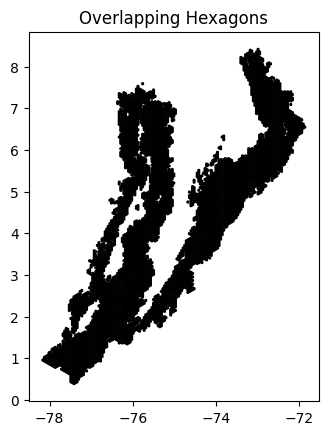

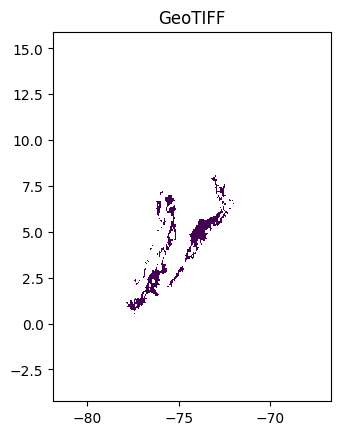

In [53]:
# Set this to a column name in the site_species_matrix to validate.
species_to_validate = 'Ensifera_ensifera'
output_fn = os.path.join('output', f'{species_to_validate}_overlapping_hexagons.shp')
overlapping_hexagons = save_overlapping_hexagons(site_species_matrix_fn, shapefile_path, species_to_validate)

# Save the overlapping hexagons to a new shapefile
overlapping_hexagons.to_file(output_fn)

# Plot the overlapping hexagons in a separate figure
ax1 = plt.subplot()
overlapping_hexagons.plot(ax=ax1)
ax1.set_title("Overlapping Hexagons")

# Show the plot for the overlapping hexagons
plt.show()

# Plot the GeoTIFF in a separate figure
ax2 = plt.subplot()
with rasterio.open(species_raster_map[species_to_validate]) as src:
    show(src, ax=ax2)
    ax2.set_title("GeoTIFF")

# Show the plot for the GeoTIFF
plt.show()